In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import plotly.express as px


In [2]:
supply = pd.read_excel(r"C:\Users\parke\Desktop\drivers_acceptance_price.csv")
supply = supply.rename(columns = str.lower)

supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pay       1000 non-null   float64
 1   accepted  1000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


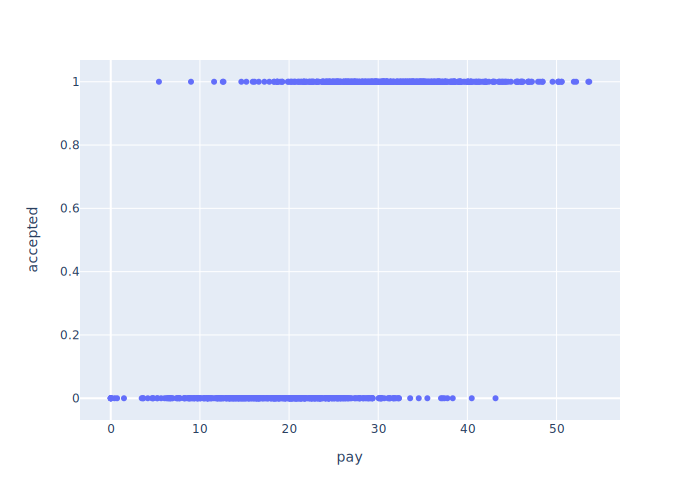

In [3]:
px.scatter(supply, x = 'pay', y = 'accepted').show('svg')

In [4]:
logit = smf.logit("accepted ~ pay", supply).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.394998
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accepted   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                  0.4289
Time:                        15:55:23   Log-Likelihood:                -395.00
converged:                       True   LL-Null:                       -691.69
Covariance Type:            nonrobust   LLR p-value:                4.606e-131
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3158      0.409    -15.455      0.000      -7.117      -5.515
pay            0.2539      0.016     15.979      0.000       0.223       0.285
==============================================================================
"""

In [7]:
plot_payouts = pd.Series(np.arange(0,60, step  =.25), name = 'pay')
predictions = pd.Series(logit.predict(plot_payouts), name = 'pred_prob')
a = pd.DataFrame({'pay':plot_payouts,'pred_prob':predictions})
px.scatter(a, 
            x = 'pay', 
            y = 'pred_prob',
            title = 'Probability of accepting ride based on payout',
            height = 800,
            width = 1600).show()



## First Pass Version: Very slow 

In [ ]:
# se tthe number of simulations to run
n = 100

# 1 period per month, 12 months
num_periods =12
period = np.arange(0,num_periods)

# Additional parameters
rider_pool = 10000
acquisition_cost = 30
ride_cost = 30

# Coarse grid of acquisitions and rider payments
acquisition_grid = [500,750,1000]
pay_grid = [10,15,20]

overall_summaries = []
monthly_summaries = []
pay_vectors = []
acquisition_vectors = []

for i in range(n):


    # Generate a dataframe of all potential riders for each month
    rider = pd.Series(data = np.arange(start = 0, stop =rider_pool), name = 'rider')
    month = pd.Series(data = np.arange(start = 0, stop = num_periods), name = 'month')

    data = pd.merge(rider, month, how = 'cross')
    data = data.assign(acquired = 0,
                        acquisition_month = np.NaN,
                        lam = 0,
                        requests = 0,
                        matches = 0
                    )

    non_acquired = np.arange(0, rider_pool)
    acquired_rider_list = np.array([])

    acquisition_list = np.array([])
    pay_list = np.array([])


    for t in period:

        # draw a number of acquisitions and driver payout for the period
        acquisitions = np.random.choice(acquisition_grid, size = 1)
        acquisition_list = np.concatenate((acquisition_list,acquisitions))

        pay = pd.Series(np.random.choice(pay_grid, size= 1), name = 'pay')
        pay_list = np.concatenate((pay_list,pay))

        # determine the probability that a ride is matched given the payout
        match_prob = logit.predict(pay).iat[0]

        # select the riders to be acquired this period and remove them from the non_acquired list
        acquired = np.random.choice(non_acquired, size = acquisitions, replace = False)
        non_acquired = np.setdiff1d(non_acquired, acquired)
        acquired_rider_list = np.concatenate((acquired_rider_list, acquired))

        # update the relevant columns for the newly acquired
        data.loc[(data['rider'].isin(acquired)) & (data['month'] >= t), 'acquired'] = 1
        data.loc[data['rider'].isin(acquired), 'acquisition_month'] = t
        data.loc[(data['rider'].isin(acquired)) & (data['month'] == t), 'lam'] = 1
        #data.loc[(data['rider'].isin(acquired)) & (data['month'] == t), 'acq_cost'] = acquisition_cost


        # update lambda for the already acquired
        data.loc[(data['month'] == t) & (data['acquired'] == 1) & (data['acquisition_month'] < t) & (data['month'] != 0), 'lam'] = data.groupby(['rider'])['matches'].shift(1)

        # compute ride requests and successful matches for all acquired riders
        filters = (data['rider'].isin(acquired_rider_list)) & (data['month'] == t)
        
        data.loc[filters, 'requests'] = data['lam'].apply(lambda x: np.random.poisson(x, size = 1)[0])
        data.loc[filters, 'matches'] = data['requests'].apply(lambda x: np.round(match_prob*x))

    # save out the pay and acquisition vectors
    pay_series = pd.Series(data = pay_list, name= 'pay')
    acquisition_series = pd.Series(data = acquisition_list, name = 'acquisitions')

    # Add in final useful columns
    df = data.merge(pay_series, how = 'left', left_on='month', right_index= True)
    df['rider_spend'] = df['matches'].multiply(ride_cost)
    df['driver_pay'] = df['matches']*df['pay']
    df['acquisition_cost'] = 0
    df.loc[df['acquisition_month'] == df['month'], 'acquisition_cost'] = 30
    df['profit'] = df['rider_spend'] - df['driver_pay'] - df['acquisition_cost']

    summary = df[['requests','matches','rider_spend','driver_pay','acquisition_cost','profit']].sum()
    monthly_summary = df.groupby('month', as_index = False)[['requests','matches','rider_spend','driver_pay','acquisition_cost','profit']].sum()

    overall_summaries.append(summary)
    monthly_summaries.append(monthly_summary)
    pay_vectors.append(pay_series)
    acquisition_vectors.append(acquisition_series)

pv_df  = pd.DataFrame(data = pay_vectors).reset_index(drop  =True)
ac_df  = pd.DataFrame(data = acquisition_vectors).reset_index(drop = True)
s_df  = pd.DataFrame(data = overall_summaries).reset_index(drop = True)


In [ ]:
pv_df  = pd.DataFrame(data = pay_vectors).reset_index(drop  =True)
ac_df  = pd.DataFrame(data = acquisition_vectors).reset_index(drop = True)
s_df  = pd.DataFrame(data = overall_summaries).reset_index(drop = True)

pv_df['simulation'] = np.arange(0,n,1)
pv_df['simulation_profit'] = s_df['profit']
pv = pd.melt(pv_df, id_vars= ['simulation','simulation_profit'], var_name = 'month', value_name= 'pay')


ac_df['simulation'] = np.arange(0,n,1)
ac_df['simulation_profit'] = s_df['profit']
ac = pd.melt(ac_df, id_vars= ['simulation','simulation_profit'], var_name = 'month', value_name= 'acquisitions')

s_df['avg_pay'] = s_df['driver_pay']/s_df['matches']
s_df['match_rate'] = s_df['matches']/s_df['requests']
s_df['acquisitions'] = np.divide(s_df['acquisition_cost'], acquisition_cost)

s_df.head()

In [ ]:
px.scatter(s_1, 
    x = 'avg_pay', 
    y = 'match_rate',
    color = 'profit',
    height=  800,
    width = 1000,
    title = "Relationship between average driver pay and match rate").show()

In [ ]:
px.scatter(s_1, 
    x = 'acquisitions', 
    y = 'profit',
    color = 'avg_pay',
    height=  800,
    width = 1000,
    title = "Relationship between acquisitions and profit over all 12 months").show()

In [ ]:
px.scatter(s_1, 
    x = 'avg_pay', 
    y = 'profit',
    color = 'acquisitions',
    height=  800,
    width = 1000,
    title = "Relationship between average driver pay and profit").show()

In [ ]:
px.scatter(s_df, 
    x = 'match_rate', 
    y = 'profit',
    color = 'acquisitions',
    trendline = 'ols',
    height=  800,
    width = 1000,
    title = "Relationship between match rate and profit").show()

In [ ]:
s_df['simulation'] = np.arange(0,n,1)
top_sims = s_df.sort_values(by = 'profit', ascending = False)['simulation'].head()

print("Simulations with the highest profits:")
s_df.sort_values(by = 'profit', ascending = False).head()



In [ ]:
px.histogram(s_1, 
            x = 'profit',
            title = "Distribution of profits across n simulations").show()

In [ ]:
s_1.describe()

In [ ]:
px.line(pv.query("simulation in @top_sims "), 
    x = 'month',
    y = 'pay', 
    color = 'simulation',
    title = "Payout Vectors for simulations with highest profit").show()

In [ ]:
px.line(ac.query("simulation in @top_sims "), 
    x = 'month',
    y = 'acquisitions', 
    color = 'simulation',
    title = "Acquisition Vectors for simulations with highest profit").show()

In [ ]:
px.line(pv, 
        x = 'month', 
        y = 'pay', 
        color = 'simulation_profit',
        color_discrete_sequence= px.colors.sequential.Plasma_r).show()

In [ ]:
pv_2 = pv_df
ac_2 = ac_df
s_2 = s_df



In [31]:
p = pd.Series(25, name = 'pay')
np.round(logit.predict(p).iat[0])

1.0

## "Full Numpy" Version: Blazing fast, about 1000 simulations per minute 

In [66]:
# set the number of simulations to run
n = 1000

# 1 period per month, 12 months
num_periods = 12
period = np.arange(0,num_periods)

# Additional parameters
rider_pool = 10000
acquisition_cost = 30
ride_cost = 30

# Coarse grid of acquisitions and rider payments
acquisition_grid = np.arange(0,1000,50)         #[0,250,500,750,1000]
pay_grid = np.arange(10,40,2)

# Arrays for storing the simulation outputs
sim_payouts = np.empty(shape = (n,num_periods))
sim_acquisitions = np.empty(shape = (n,num_periods))
sim_requests = np.empty(shape = (n,num_periods))
sim_matches = np.empty(shape = (n,num_periods))
sim_profit = np.empty(shape = (n,num_periods)) 

for s in range(n):   
    
    # initiate blank slate rider status lists
    riders = np.arange(0, rider_pool)                           # list of all possible riders
    non_acquired_riders = np.arange(0,rider_pool)               # list of riders that have yet to be acquired: list updates every period

    # initiate blank slate rider data
    acquired = np.zeros((rider_pool,num_periods))               # per period matrix indicating if a rider has been acquired: 0 up to their acq month then 1 in this month and after
    acquisition_month = np.zeros((rider_pool,num_periods))      # per period matrix indicating the month a rider was acquired
    lamb = np.zeros((rider_pool,num_periods))                   # per period matrix indicating the lambda governing the riders ride requests for a given rider in that period
    requests = np.zeros((rider_pool,num_periods))               # per periood martrix indicating the number or rider requests for a given rider in that period
    matches = np.zeros((rider_pool,num_periods))                # per period matrix indicating the number of matched rides for a given rider in that period

    for t in period:    
        
        # Get the pay and number of acquisitions for the period
        pay = np.round(np.random.uniform(low = 10, high = 35, size = 1)[0])
        num_acquisitions = np.random.randint(low = 0, high = 1000, size = 1)[0]
        sim_payouts[s,t] = pay
        sim_acquisitions[s,t] = num_acquisitions

         # determine the probability that a ride is matched given the payout
        p = pd.Series(pay, name = 'pay')
        acceptance_probability = logit.predict(p).iat[0]
    
        # Get the new acquisitions for the month and remove them from the pool
        if non_acquired_riders.size > 0:
            newly_acquired_riders = non_acquired_riders[0:num_acquisitions]                     # grab the new acquired riders
            previously_acquired_riders = np.setdiff1d(riders, non_acquired_riders)              # update the previosuly acquired rider list prior to updating the non acquired rider list
            non_acquired_riders = np.setdiff1d(non_acquired_riders, newly_acquired_riders)      # update the non acquired rider list so above two lists are correct next period
            
            # update data for newly acquired riders
            acquired[newly_acquired_riders, t:] = 1             # 1 in all months therafter
            acquisition_month[newly_acquired_riders,t] = 1      # 1 in this month only
            lamb[newly_acquired_riders, t] = 1                  # lambda = 1 for all new riders
            requests[newly_acquired_riders, t] = np.random.poisson(lam = lamb[newly_acquired_riders, t], size = num_acquisitions)           
            matches[newly_acquired_riders,t] = np.round(np.multiply(requests[newly_acquired_riders, t], acceptance_probability))

        # update data for previously acquired riders
        if t>0:
            lamb[previously_acquired_riders, t] = matches[previously_acquired_riders, t-1]
            requests[previously_acquired_riders, t] = np.random.poisson(lam = lamb[previously_acquired_riders, t], size = previously_acquired_riders.size)
            matches[previously_acquired_riders,t] = np.round(np.multiply(requests[previously_acquired_riders, t], acceptance_probability))
        
        # per period simulation results
        monthly_acq = np.sum(acquisition_month, axis = 0)
        monthly_matches = np.sum(matches, axis = 0)
        sim_requests[s] = np.sum(requests, axis = 0)
        sim_matches[s] = np.sum(matches, axis = 0)
        sim_profit[s] = monthly_matches*ride_cost - monthly_matches*pay - monthly_acq*acquisition_cost


print('simulations complete')



simulations complete


In [117]:
# Prepare output for inspection

profit_results = pd.DataFrame(data = {'profit':np.sum(sim_profit, axis = 1)})
profit_results['simulation'] = np.arange(0,n)
profit_results['percentile'] = pd.qcut(profit_results.profit, q =100, labels=np.arange(100))
#top_100= profit_results.sort_values(by = 'profit', ascending = False)['simulation'].head(100)
#bottom_100= profit_results.sort_values(by = 'profit', ascending = True)['simulation'].head(100)

payout_vectors = pd.DataFrame(data = sim_payouts)
payout_vectors['profit'] = np.sum(sim_profit, axis = 1)
payout_vectors['percentile']= pd.qcut(profit_results.profit, q =100, labels=np.arange(100))
payout_vectors['simulation'] = np.arange(0,n)
pv_wide = pd.melt(payout_vectors, id_vars=['simulation','profit','percentile'], var_name = 'month', value_name = 'payout')

acquisition_vectors = pd.DataFrame(data = sim_acquisitions)
acquisition_vectors['profit'] = np.sum(sim_profit, axis = 1)
acquisition_vectors['percentile'] = pd.qcut(profit_results.profit, q =100, labels=np.arange(100))
acquisition_vectors['simulation'] = np.arange(0,n)
av_wide = pd.melt(acquisition_vectors, id_vars=['simulation','profit','percentile'], var_name = 'month', value_name = 'acquisition')

profit_results.sort_values(by = 'profit', ascending = False).head(10)


,profit,simulation,percentile
447,73348.0,447,99
790,47621.0,790,99
996,20286.0,996,99
414,-4854.0,414,99
706,-7500.0,706,99
70,-23183.0,70,99
91,-28226.0,91,99
52,-32460.0,52,99
173,-43440.0,173,99
429,-44730.0,429,99


In [118]:
percentiles = [0,1,2,97,98,99]
df = pv_wide.astype({'percentile':'object'}).query("percentile in @percentiles")
df.head()

,simulation,profit,percentile,month,payout
52,52,-32460.0,99,0,21.0
70,70,-23183.0,99,0,32.0
78,78,-246468.0,1,0,33.0
91,91,-28226.0,99,0,34.0
145,145,-257872.0,0,0,33.0


In [126]:
df = pv_wide.astype({'percentile':'object'}).query("percentile in @percentiles")
df.head()

px.scatter(df, 
        x = 'month', 
        y = 'payout', 
        color = 'percentile',
        #hover_data = ['simulation','profit'],
        trendline = 'lowess',
        title = "Payout strategy vectors for the best and worst simulations",
        height = 800,
        width = 1600).show()

In [125]:
percentiles = [0,1,2,97,98,99]
df = av_wide.astype({'percentile':'object'}).query("percentile in @percentiles")
df.head()

px.scatter(df, 
        x = 'month', 
        y = 'acquisition', 
        color = 'percentile',
        trendline = 'lowess',
        hover_data = ['simulation','profit'],
        title = "Acquisition strategy vectors for the top performing simulations",
        height = 800,
        width = 1600).show()